In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from gemelli.joint_ctf import joint_ctf
from gemelli.tempted import tempted_factorize
from helper_functions import (create_sim_data, plot_mean_signal,
                              plot_loadings)
from biom import load_table

fig_path = '/Users/bec5786/Desktop/temp_figs/'
%matplotlib inline
data_path = '../ipynb/tutorials/'

### Functions

In [2]:
group_colors = {'group1': 'tab:red', 
                'group2': 'tab:blue',
                'group3': 'tab:green'}

def sine_func(x,tps=10):
    amp = 1
    phase = 0
    t = np.linspace(0, 1, tps)
    signal = amp*(1+np.sin(2*np.pi*(t + phase)))
    return np.multiply(x, signal)

def sigmoid(x,tps=10):
    t = np.linspace(-6, 6, tps)
    signal = 1/(1+np.exp(-t))
    return np.multiply(x, signal)

### Test 1

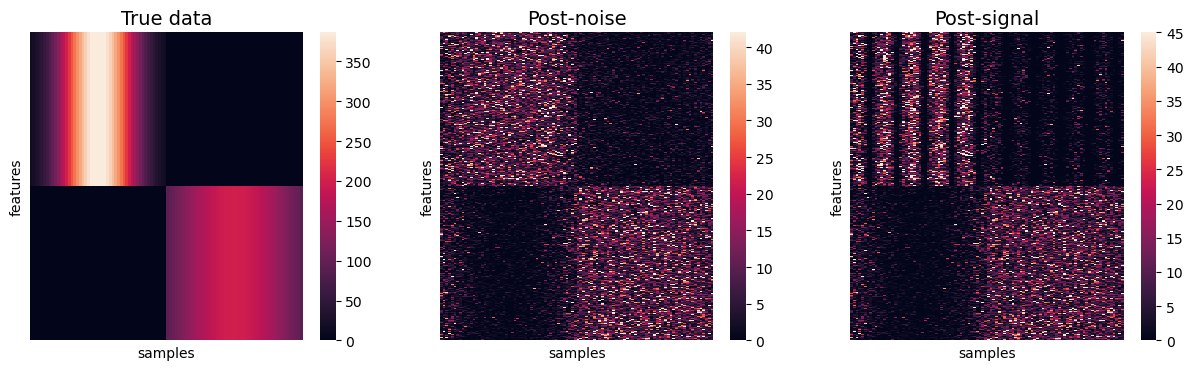

In [3]:
_, _, noisy_mod1, mf_mod1 = create_sim_data('mod1', n_timepoints=10, n_subjects=10, 
                                            num_samples=100, num_features=500,
                                            rank=2, C_=2e3, spar=2e3,
                                            fxs=[sine_func], f_intervals=[[(0,250)]], 
                                            s_intervals=[[(0,100)]], plotting=True,
                                            col_handle='individual')

In [4]:
# #save data
# with open("noisy_mod1.biom", "w") as f:
#     noisy_mod1.to_json("Table for lambda experiments", f)
# #save metadata
# mf_mod1.to_csv("mf_mod1.csv")

In [ ]:
#load data, if coming back
#noisy_mod1 = load_table('noisy_mod1.biom') 
#mf_mod1 = pd.read_csv('mf_mod1.csv', index_col=0)

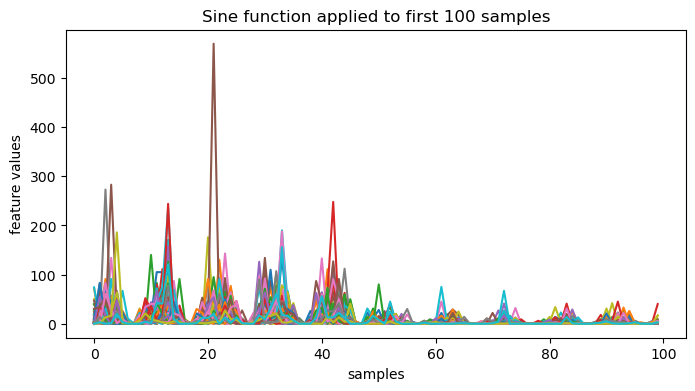

In [4]:
n_samples=100
n_features=3

#plot sine function applied to first few samples
plt.figure(figsize=(8, 4))
plt.plot(noisy_mod1.to_dataframe().values[0:100, 0:n_samples].T, 
         label=noisy_mod1.to_dataframe().index[0:100])
plt.xlabel('samples')
plt.ylabel('feature values')
plt.title('Sine function applied to first {} samples'.format(n_samples))
#plt.legend()
plt.show()

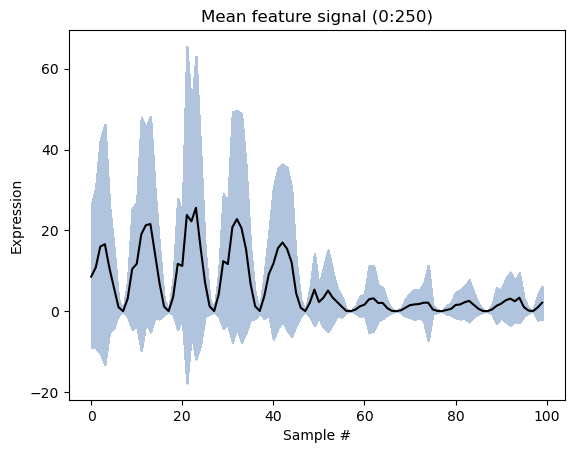

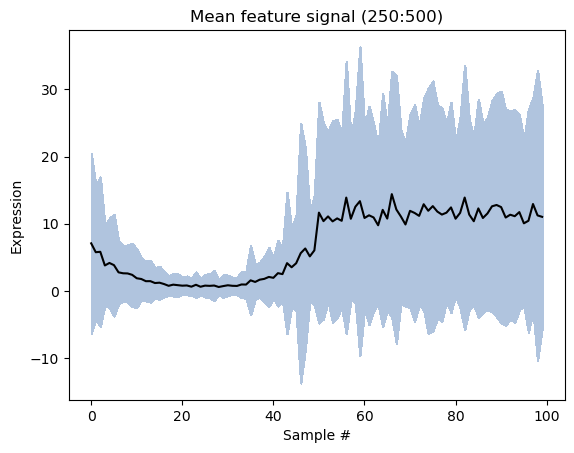

In [7]:
plot_mean_signal(noisy_mod1, features=[0, 250], samples=None)
plot_mean_signal(noisy_mod1, features=[250, 500], samples=None)

In [5]:
#run joint-ctf
(mod1_subject_loads, mod1_feature_loads, 
mod1_state_loads, mod1_subject_lambdas,
mod1_var_explained, mod1_feature_covs) = joint_ctf(tables=[noisy_mod1],
                                                   sample_metadatas=[mf_mod1],
                                                   modality_ids=['mod1'],
                                                   individual_id_column='ind_id',
                                                   state_column='timepoint')

Calculate components for component_1
Reached convergence in 7 iterations
Calculate components for component_2
Reached convergence in 10 iterations
Calculate components for component_3
Reached convergence in 9 iterations


In [6]:
print(mod1_subject_lambdas)
print(mod1_var_explained.T)

      component_1  component_2  component_3
mod1  3892.700258  1896.534859  1875.223684
               component_1  component_2  component_3
var_explained     0.676945     0.300588     0.022467


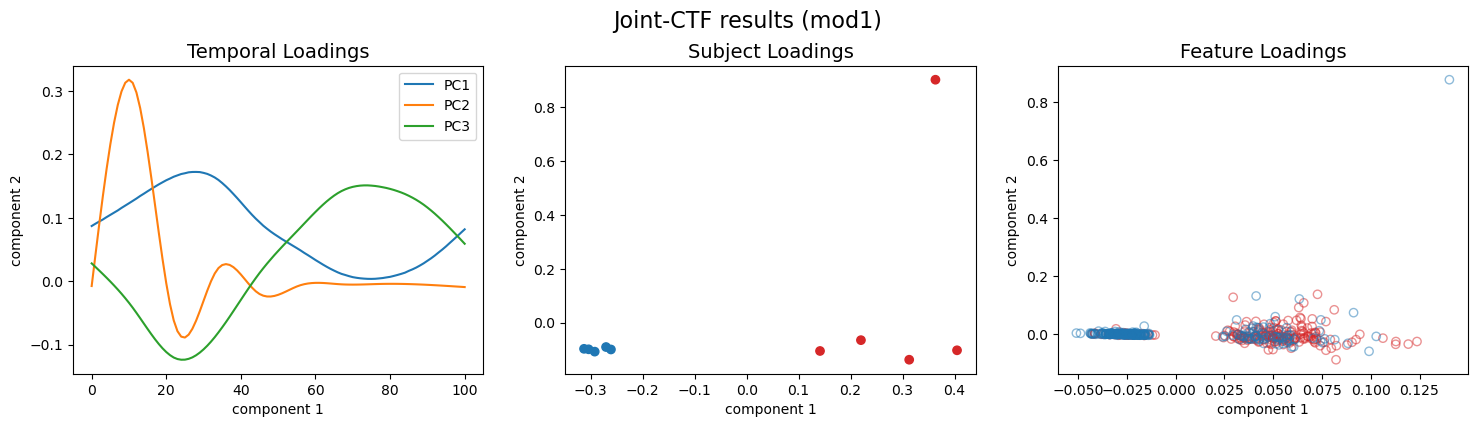

In [7]:
plot_loadings(loadings=[mod1_state_loads, mod1_feature_loads, mod1_subject_loads],
              mf=mf_mod1, group_colors=group_colors, title='Joint-CTF results',
              comp1='component_1', comp2='component_2', mod_name='mod1',
              ft_groups=[(0,250),(250,500)], ft_names=['group1','group2'])

In [8]:
tempted_res_noisy1 = tempted_factorize(noisy_mod1, mf_mod1,
                                      'ind_id', 'timepoint')

Prop explained: [0.1505911  0.04319405 0.03930857]
Prop explained argsort: [0 1 2]
Eigenvalues pre-sorting: [3894.54218639 1900.4280935  1872.79003104]
Eigenvalues post-sorting: [3894.54218639 1900.4280935  1872.79003104]


In [9]:
tempted_res_noisy1[0].proportion_explained

PC1    0.150591
PC2    0.043194
PC3    0.039309
dtype: float64

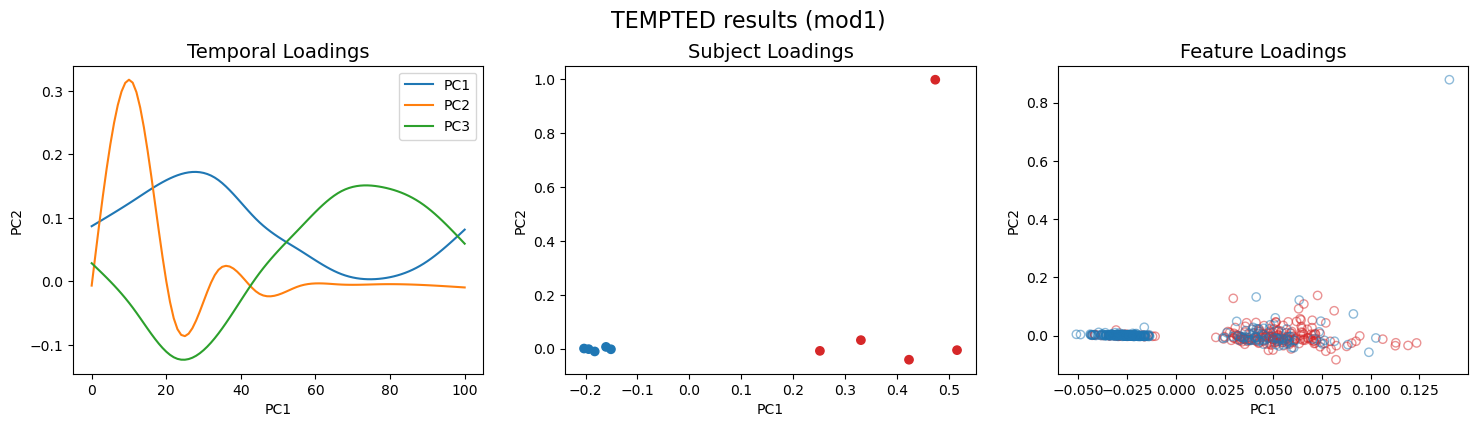

In [10]:
plot_loadings(loadings=[{'mod1':tempted_res_noisy1[1]}, 
                        {'mod1':tempted_res_noisy1[0].features}, 
                        {'mod1':tempted_res_noisy1[0].samples}],
              mf=mf_mod1, group_colors=group_colors, title='TEMPTED results',
              comp1='PC1', comp2='PC2', mod_name='mod1',
              ft_groups=[(0,250),(250,500)], ft_names=['group1','group2'])

In [17]:
test_ = mod1_feature_loads['mod1'][['component_1', 'component_2', 'component_3']]
test_.head()

,component_1,component_2,component_3
mod1F1,0.047896,-0.009029,0.044167
mod1F10,0.057206,-0.008819,0.065714
mod1F100,0.038792,-0.025216,0.051008
mod1F101,0.080205,-0.041265,0.065394
mod1F102,0.059213,0.000539,0.078686


In [ ]:
sgn_feature_loadings = np.sign(test_.sum(axis=0))
#sgn_feature_loadings['component_2'] = -1
sgn_feature_loadings

component_1    1.0
component_2   -1.0
component_3    1.0
dtype: float64

In [ ]:
#test_ = test_*sgn_feature_loadings
#test_